# Mutual Information (MNIST)

Эксперименты с оценкой энтропии для данных рукописных цифр.

# Преамбула

### Tensorflow

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

tfds.disable_progress_bar()
tf.enable_v2_behavior()

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices()

2.6.0
Num GPUs Available:  2


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

### Math, Numpy, Scipy, Pandas

In [2]:
import math
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.linalg as spl
import pandas as pd

### Matplotlib, Seaborn

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6jp39hx4 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Sklearn

In [4]:
# Метод главных компонент.
from sklearn.decomposition import PCA

# Выбор модели по кросс-валидации (поиск по сетке).
from sklearn.model_selection import GridSearchCV

### Joblib

In [5]:
from joblib import Parallel, delayed

global_n_jobs = 32

### OS, shutil, Json, CSV, copy

In [6]:
import os
import shutil
import json
import csv
import copy

### Mutinfo

In [7]:
import sys
sys.path.insert(0, './py')

In [8]:
from mutinfo.estimators.mutual_information import MutualInfoEstimator
from mutinfo.keras.layers import TunableGaussianNoise

## Вспомогательное

In [9]:
# Глобальная информация.
global_info = dict()

In [10]:
# Информация об опыте.
info = dict()

In [11]:
def normalize_uint8(data, label):
    """Нормализация: `uint8` -> `float32`."""
    return tf.cast(data, tf.float32) / 255.0, label

In [12]:
def imshow_array(array):
    """Отображение массива нормированных пикселей."""
    plt.axis('off')
    plt.imshow((255.0 * array).astype(np.uint8), cmap=plt.get_cmap("gray"), vmin=0, vmax=255)

In [13]:
def dataset_Y_to_X(X, Y):
    """Поменять у датасета пары (X, Y) на (X, X) (нужно, например, для обучения автоэнкодера)."""
    return X, X

In [14]:
def concave_loss(y_true, y_pred):
    """Вогнутая функция потерь, дающая более четкие изображения при обучении."""
    delta = tf.keras.backend.abs(y_true - y_pred)
    squared = tf.keras.backend.square(y_true - y_pred)
    return tf.keras.backend.mean(delta - 0.5 * squared, axis=-1)

## Путь к папке с данными

In [15]:
#path = "/content/drive/My Drive/Information_v2/"
path = os.path.abspath(os.getcwd()) + "/data/"

In [16]:
experiments_path = path + "mutual_information/MNIST/"
models_path = experiments_path + "models/"

In [17]:
mnist_shape = (28, 28, 1)

### Полный набор данных

In [18]:
(ds_full_train, ds_full_test), ds_info = tfds.load(
    'mnist',
    data_dir=path + 'tensorflow_datasets/',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [19]:
ds_full_train = ds_full_train.map(normalize_uint8, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_full_test  = ds_full_test.map(normalize_uint8, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [20]:
ds_train = ds_full_train.take(60000)
ds_train = np.array([sample for sample in ds_train])

ds_test  = ds_full_test.take(60000)
ds_test  = np.array([sample for sample in ds_test])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [21]:
ds_train_X = ds_train[:,0]
ds_test_X  = ds_test[:,0]

In [22]:
ds_train_Y = ds_train[:,1]
ds_test_Y = ds_test[:,1]

## Автокодировщик для изображений

### Тренировочные и тестовые наборы

In [23]:
ae_batch_size = 2048

In [24]:
(ds_ae_train, ds_ae_test), ds_info = tfds.load(
    'mnist',
    data_dir=path + 'tensorflow_datasets/',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [25]:
ds_ae_train = ds_ae_train.map(normalize_uint8, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_ae_train = ds_ae_train.map(dataset_Y_to_X, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_ae_train = ds_ae_train.cache()
ds_ae_train = ds_ae_train.shuffle(ds_info.splits['train'].num_examples)
ds_ae_train = ds_ae_train.batch(ae_batch_size)
ds_ae_train = ds_ae_train.prefetch(tf.data.experimental.AUTOTUNE)

In [26]:
ds_ae_test = ds_ae_test.map(normalize_uint8, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_ae_test = ds_ae_test.map(dataset_Y_to_X, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_ae_test = ds_ae_test.batch(ae_batch_size)
ds_ae_test = ds_ae_test.cache()
ds_ae_test = ds_ae_test.prefetch(tf.data.experimental.AUTOTUNE)

### Автокодировщик

In [27]:
# РАЗМЕРНОСТЬ КОДА.
# #
# #

codes_dim_X = 10 # MNSIT

# #
# #

In [28]:
def cnn_autoencoder(shape_input, dimension):
    # Инициализация весов.
    init = tf.keras.initializers.RandomNormal(stddev = 1.0)

    # Входные данные генератора / выборки.
    input_layer = tf.keras.layers.Input(shape_input)
    next_layer = input_layer

    # 1 блок слоёв.
    next_layer = tf.keras.layers.GaussianNoise(0.1)(next_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    #next_layer = tf.keras.layers.Dropout(0.1)(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)

    # 2 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(next_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 18, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1)(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)

    # 3 блок слоёв.
    next_layer = tf.keras.layers.GaussianNoise(0.1)(next_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 27, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1)(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)

    # Бутылочное горлышко.
    next_layer = tf.keras.layers.Flatten()(next_layer)
    next_layer = tf.keras.layers.Dense(dimension)(next_layer)
    bottleneck = tf.keras.layers.Activation('tanh')(next_layer)

    # Модель кодировщика.
    encoder = tf.keras.Model(input_layer, bottleneck)

    # Начало модели декодировщика.
    input_code_layer = tf.keras.layers.Input((dimension))
    next_layer = input_code_layer

    # 3 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(next_layer)
    next_layer = tf.keras.layers.Dense(4*4*27)(next_layer)
    next_layer = tf.keras.layers.Reshape((4, 4, 27))(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    #next_layer = tf.keras.layers.Dropout(0.2)(next_layer)

    # 2 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(next_layer)
    next_layer = tf.keras.layers.UpSampling2D(size=(2, 2))(next_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 18, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.Cropping2D(cropping=((0, 1), (0, 1)))(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    #next_layer = tf.keras.layers.Dropout(0.1)(next_layer)

    # 1 блок слоёв.
    next_layer = tf.keras.layers.GaussianNoise(0.1)(next_layer)
    next_layer = tf.keras.layers.UpSampling2D(size=(2, 2))(next_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1)(next_layer)

    # 0 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(next_layer)
    next_layer = tf.keras.layers.UpSampling2D(size=(2, 2))(next_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 1, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.Activation('sigmoid')(next_layer)
    #next_layer = tf.keras.layers.Dropout(0.1)(next_layer)

    output_layer = next_layer

    # Модель.
    decoder = tf.keras.models.Model(input_code_layer, output_layer) # Декодировщик.
    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Компиляция модели.
    opt = tf.keras.optimizers.Adam(learning_rate = 5e-3)
    autoencoder.compile(loss = concave_loss, optimizer = opt, loss_weights = [1.0])
    return encoder, decoder, autoencoder

In [29]:
load_X_autoencoder = True#False

In [30]:
if load_X_autoencoder:
    encoder_X = tf.keras.models.load_model(models_path + "autoencoder/encoder_X.h5")
    decoder_X = tf.keras.models.load_model(models_path + "autoencoder/decoder_X.h5")
    autoencoder_X = tf.keras.Sequential([encoder_X, decoder_X])
    autoencoder_X.compile(loss = concave_loss, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss_weights = [1.0])

In [31]:
if not load_X_autoencoder:
    encoder_X, decoder_X, autoencoder_X = cnn_autoencoder(mnist_shape, codes_dim_X)
    
    autoencoder_X.fit(
        ds_ae_train,
        epochs=300,
        validation_data=ds_ae_test
    )
    
    # Сохранение моделей.
    autoencoder_X.save(models_path + "/autoencoder/autoencoder_X.h5")
    encoder_X.save(models_path + "/autoencoder/encoder_X.h5")
    decoder_X.save(models_path + "/autoencoder/decoder_X.h5")

## Классификатор изображений

In [32]:
epochs_counter = 0

In [33]:
# Номер исследуемого слоя.
layer_index = 5

# Стандартное отклонение шума, добавляемого к слоям.
layers_noise_std = 5e-2

In [34]:
next_epoch = 200

In [35]:
delta_epochs = next_epoch - epochs_counter
epochs_counter = next_epoch

In [36]:
dataset_path = experiments_path + ("%.1e" % layers_noise_std) + "/" + "layer_" + str(layer_index) + "/" + str(epochs_counter) + "/"

In [37]:
full_path = dataset_path + "autoencoders/"
os.makedirs(full_path, exist_ok=True)

### Тренировочные и тестовые наборы

In [38]:
cl_batch_size = 5000

In [39]:
(ds_cl_train, ds_cl_test), ds_info = tfds.load(
    'mnist',
    data_dir=path + 'tensorflow_datasets/',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [40]:
ds_cl_train = ds_cl_train.map(normalize_uint8, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_cl_train = ds_cl_train.cache()
ds_cl_train = ds_cl_train.shuffle(ds_info.splits['train'].num_examples)
ds_cl_train = ds_cl_train.batch(cl_batch_size)
ds_cl_train = ds_cl_train.prefetch(tf.data.experimental.AUTOTUNE)

In [41]:
ds_cl_test = ds_cl_test.map(normalize_uint8, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_cl_test = ds_cl_test.batch(cl_batch_size)
ds_cl_test = ds_cl_test.cache()
ds_cl_test = ds_cl_test.prefetch(tf.data.experimental.AUTOTUNE)

### Классификатор

In [42]:
def convolutional_classifier(shape_input):
    # Инициализация весов.
    init = tf.keras.initializers.RandomNormal(stddev = 0.02)

    # Входные данные генератора / выборки.
    input_layer = tf.keras.layers.Input(shape_input)
    next_layer = input_layer
    next_layer = TunableGaussianNoise(layers_noise_std, name='GaussianNoise_0')(next_layer)

    # 1 блок слоёв.  
    next_layer = tfa.layers.SpectralNormalization(
        tf.keras.layers.Conv2D(
            filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init
        ),
        name='SN_1'
    )(next_layer)
    
    #next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1, name='Dropout_1')(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)
    next_layer = TunableGaussianNoise(layers_noise_std, name='GaussianNoise_1')(next_layer)

    output_layer_1 = next_layer

    # 2 блок слоёв. 
    next_layer = tfa.layers.SpectralNormalization(
        tf.keras.layers.Conv2D(
            filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init
        ),
        name='SN_2'
    )(next_layer)
    
    next_layer = tf.keras.layers.BatchNormalization(name='BatchNormalization_2')(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1, name='Dropout_2')(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)
    next_layer = TunableGaussianNoise(layers_noise_std, name='GaussianNoise_2')(next_layer)

    output_layer_2 = next_layer

    # 3 блок слоёв.
    next_layer = tfa.layers.SpectralNormalization(
        tf.keras.layers.Conv2D(
            filters = 16, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init
        ),
        name='SN_3'
    )(next_layer)
    
    next_layer = tf.keras.layers.BatchNormalization(name='BatchNormalization_3')(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1, name='Dropout_3')(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)
    next_layer = TunableGaussianNoise(layers_noise_std, name='GaussianNoise_3')(next_layer)

    output_layer_3 = next_layer
    
    # 4 блок слоёв.
    next_layer = tf.keras.layers.Flatten()(next_layer)
    
    next_layer = tfa.layers.SpectralNormalization(
        tf.keras.layers.Dense(16),
        name='SN_4'
    )(next_layer)
    
    next_layer = tf.keras.layers.BatchNormalization(name='BatchNormalization_4')(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = TunableGaussianNoise(layers_noise_std, name='GaussianNoise_4')(next_layer)

    output_layer_4 = next_layer
    
    # 5 блок слоёв.
    next_layer = tfa.layers.SpectralNormalization(
        tf.keras.layers.Dense(10),
        name='SN_5'
    )(next_layer)
    
    next_layer = tf.keras.layers.BatchNormalization(name='BatchNormalization_5')(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Activation('tanh')(next_layer)
    next_layer = TunableGaussianNoise(layers_noise_std, name='GaussianNoise_5')(next_layer)

    output_layer_5 = next_layer

    # Вывод.
    #next_layer = tf.keras.layers.Flatten()(next_layer)
    next_layer = tf.keras.layers.Dense(10)(next_layer)
    output_layer = tf.keras.layers.Activation('softmax')(next_layer)

    # Модель.
    debug_model = tf.keras.models.Model([input_layer],
                                        [output_layer_1,
                                         output_layer_2,
                                         output_layer_3,
                                         output_layer_4,
                                         output_layer_5])
    model = tf.keras.models.Model(input_layer, output_layer)

    # Компиляция модели.
    opt = tf.keras.optimizers.Adam(lr = 1e-3)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt,
                  loss_weights = [1.0], metrics=['accuracy'])
    return model, debug_model

In [43]:
load_X_classifier = False

In [44]:
# Загрузка модели.
if load_X_classifier:
    classifier = tf.keras.models.load_model(models_path + "/classifier/classifier.h5")
    debug_classifier = tf.keras.models.load_model(models_path + "/classifier/debug_classifier.h5")

In [45]:
if not load_X_classifier:
    classifier, debug_classifier = convolutional_classifier(mnist_shape)
    # Сводка по модели.
    classifier.summary()
    # Отрисовка модели.
    #tf.keras.utils.plot_model(classifier, show_shapes = True, show_layernames = True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
GaussianNoise_0 (TunableGaus (None, 28, 28, 1)         2         
_________________________________________________________________
SN_1 (SpectralNormalization) (None, 28, 28, 64)        704       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
GaussianNoise_1 (TunableGaus (None, 14, 14, 64)        2   

/usr/local/lib/python3.6/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [46]:
history_callback = classifier.fit(
    ds_cl_train,
    epochs=delta_epochs,
    validation_data=ds_cl_test
)

Epoch 1/200
12/12 [==============================] - 8s 187ms/step - loss: 1.8973 - accuracy: 0.4116 - val_loss: 2.2579 - val_accuracy: 0.2524
Epoch 2/200
12/12 [==============================] - 1s 110ms/step - loss: 1.4324 - accuracy: 0.7428 - val_loss: 2.1951 - val_accuracy: 0.4450
Epoch 3/200
12/12 [==============================] - 1s 108ms/step - loss: 1.2401 - accuracy: 0.8386 - val_loss: 2.1257 - val_accuracy: 0.5093
Epoch 4/200
12/12 [==============================] - 1s 110ms/step - loss: 1.0960 - accuracy: 0.8855 - val_loss: 2.0740 - val_accuracy: 0.4235
Epoch 5/200
12/12 [==============================] - 1s 109ms/step - loss: 0.9817 - accuracy: 0.9139 - val_loss: 2.0422 - val_accuracy: 0.3489
Epoch 6/200
12/12 [==============================] - 1s 109ms/step - loss: 0.8892 - accuracy: 0.9306 - val_loss: 2.0101 - val_accuracy: 0.3046
Epoch 7/200
12/12 [==============================] - 1s 109ms/step - loss: 0.8115 - accuracy: 0.9422 - val_loss: 1.9786 - val_accuracy: 0.2870

Epoch 58/200
12/12 [==============================] - 1s 110ms/step - loss: 0.0793 - accuracy: 0.9920 - val_loss: 0.1304 - val_accuracy: 0.9834
Epoch 59/200
12/12 [==============================] - 1s 109ms/step - loss: 0.0769 - accuracy: 0.9921 - val_loss: 0.1436 - val_accuracy: 0.9801
Epoch 60/200
12/12 [==============================] - 1s 110ms/step - loss: 0.0748 - accuracy: 0.9926 - val_loss: 0.1076 - val_accuracy: 0.9872
Epoch 61/200
12/12 [==============================] - 1s 110ms/step - loss: 0.0741 - accuracy: 0.9924 - val_loss: 0.1171 - val_accuracy: 0.9842
Epoch 62/200
12/12 [==============================] - 1s 109ms/step - loss: 0.0713 - accuracy: 0.9929 - val_loss: 0.1099 - val_accuracy: 0.9868
Epoch 63/200
12/12 [==============================] - 1s 110ms/step - loss: 0.0698 - accuracy: 0.9930 - val_loss: 0.1090 - val_accuracy: 0.9855
Epoch 64/200
12/12 [==============================] - 1s 110ms/step - loss: 0.0681 - accuracy: 0.9930 - val_loss: 0.0998 - val_accuracy:

Epoch 115/200
12/12 [==============================] - 1s 109ms/step - loss: 0.0314 - accuracy: 0.9953 - val_loss: 0.0494 - val_accuracy: 0.9906
Epoch 116/200
12/12 [==============================] - 1s 109ms/step - loss: 0.0305 - accuracy: 0.9957 - val_loss: 0.0470 - val_accuracy: 0.9902
Epoch 117/200
12/12 [==============================] - 1s 110ms/step - loss: 0.0312 - accuracy: 0.9954 - val_loss: 0.0565 - val_accuracy: 0.9868
Epoch 118/200
12/12 [==============================] - 1s 111ms/step - loss: 0.0298 - accuracy: 0.9960 - val_loss: 0.0537 - val_accuracy: 0.9888
Epoch 119/200
12/12 [==============================] - 1s 109ms/step - loss: 0.0293 - accuracy: 0.9956 - val_loss: 0.0533 - val_accuracy: 0.9890
Epoch 120/200
12/12 [==============================] - 1s 109ms/step - loss: 0.0301 - accuracy: 0.9956 - val_loss: 0.0497 - val_accuracy: 0.9897
Epoch 121/200
12/12 [==============================] - 1s 110ms/step - loss: 0.0298 - accuracy: 0.9955 - val_loss: 0.0527 - val_ac

12/12 [==============================] - 1s 109ms/step - loss: 0.0197 - accuracy: 0.9963 - val_loss: 0.0367 - val_accuracy: 0.9905
Epoch 172/200
12/12 [==============================] - 1s 109ms/step - loss: 0.0194 - accuracy: 0.9966 - val_loss: 0.0399 - val_accuracy: 0.9901
Epoch 173/200
12/12 [==============================] - 1s 109ms/step - loss: 0.0191 - accuracy: 0.9967 - val_loss: 0.0358 - val_accuracy: 0.9909
Epoch 174/200
12/12 [==============================] - 1s 109ms/step - loss: 0.0195 - accuracy: 0.9963 - val_loss: 0.0450 - val_accuracy: 0.9888
Epoch 175/200
12/12 [==============================] - 1s 107ms/step - loss: 0.0195 - accuracy: 0.9963 - val_loss: 0.0352 - val_accuracy: 0.9918
Epoch 176/200
12/12 [==============================] - 1s 107ms/step - loss: 0.0192 - accuracy: 0.9964 - val_loss: 0.0393 - val_accuracy: 0.9898
Epoch 177/200
12/12 [==============================] - 1s 110ms/step - loss: 0.0176 - accuracy: 0.9972 - val_loss: 0.0345 - val_accuracy: 0.9910

In [47]:
loss_history = np.array(history_callback.history["loss"])
val_loss_history = np.array(history_callback.history["val_loss"])
accuracy_history = np.array(history_callback.history["accuracy"])
val_accuracy_history = np.array(history_callback.history["val_accuracy"])

info['last_loss'] = loss_history[-1]
info['last_val_loss'] = val_loss_history[-1]
info['last_accuracy'] = accuracy_history[-1]
info['last_val_accuracy'] = val_accuracy_history[-1]

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp, indent=4)

# Оценка взаимной информации

### Получение значений слоя

In [48]:
# Приходится делать predict по частям.
min_batch_number = 10

_splitted = tf.split(tf.stack(ds_train_X), min_batch_number)
_layer_predicted_train = tf.concat([debug_classifier(_splitted[i])[layer_index - 1] for i in range(min_batch_number)], 0)

_splitted = tf.split(tf.stack(ds_test_X), min_batch_number)
_layer_predicted_test = tf.concat([debug_classifier(_splitted[i])[layer_index - 1] for i in range(min_batch_number)], 0)

In [49]:
ds_train_L = np.array([_layer_predicted_train[i].numpy().flatten() for i in range(_layer_predicted_train.shape[0])])
ds_test_L  = np.array([_layer_predicted_test[i].numpy().flatten() for i in range(_layer_predicted_test.shape[0])])

## Автокодировщик

Сжатие данных предлагается делать автокодировщиком.
Для архитектуры специфицируется только формат входных данных, а также размерность внутреннего представления (кодов).

In [50]:
# РАЗМЕРНОСТЬ КОДА.
# #
# #

codes_dim_L = 4  # Слой.

# #
# #

In [51]:
# Число эпох для обучения.
autoencoders_epochs = 2000

In [52]:
info['autoencoders_epochs'] = autoencoders_epochs

### Автокодировщик для слоя

In [53]:
def dense_autoencoder(shape_input, dimension):
    # Инициализация весов.
    init = tf.keras.initializers.RandomNormal(stddev = 0.02)

    # Входные данные генератора / выборки.
    input_layer = tf.keras.layers.Input(shape_input)
    next_layer = input_layer
    next_layer = tf.keras.layers.GaussianNoise(0.02)(next_layer)

    # 1 блок слоёв.
    next_layer = tfa.layers.SpectralNormalization(tf.keras.layers.Dense(512, kernel_initializer = init),
                                                  power_iterations = 3)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1)(next_layer)

    # 2 блок слоёв.
    next_layer = tfa.layers.SpectralNormalization(tf.keras.layers.Dense(256, kernel_initializer = init),
                                                  power_iterations = 3)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1)(next_layer)
    
    # 3 блок слоёв.
    #next_layer = tfa.layers.SpectralNormalization(tf.keras.layers.Dense(128, kernel_initializer = init),
    #                                              power_iterations = 3)(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    #next_layer = tf.keras.layers.Dropout(0.1)(next_layer)
    
    # 4 блок слоёв.
    #next_layer = tfa.layers.SpectralNormalization(tf.keras.layers.Dense(32, kernel_initializer = init),
    #                                              power_iterations = 3)(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    #next_layer = tf.keras.layers.Dropout(0.1)(next_layer)
    
    # Бутылочное горлышко.
    next_layer = tfa.layers.SpectralNormalization(tf.keras.layers.Dense(dimension),
                                                  power_iterations = 3)(next_layer)
    bottleneck = tf.keras.layers.Activation('tanh', name='bottleneck')(next_layer)

    # Модель кодировщика.
    encoder = tf.keras.Model(input_layer, bottleneck)

    # Начало модели декодировщика.
    input_code_L = tf.keras.layers.Input((dimension))
    next_layer = input_code_L
    
    # 4 блок слоёв.
    #next_layer = tf.keras.layers.Dense(32, kernel_initializer = init)(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)

    # 3 блок слоёв.
    #next_layer = tf.keras.layers.Dense(128, kernel_initializer = init)(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    
    # 2 блок слоёв.
    next_layer = tf.keras.layers.Dense(256, kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)

    # 1 блок слоёв.
    next_layer = tf.keras.layers.Dense(512, kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    
    # 0 блок слоёв.
    next_layer = tf.keras.layers.Dense(shape_input[0])(next_layer) # Подразумевается, что вход - всё равно вектор.
    #next_layer = tf.keras.layers.Activation('tanh')(next_layer)
    
    output_layer = next_layer
    
    # Модель.
    decoder = tf.keras.models.Model(input_code_L, output_layer) # Декодировщик.
    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Компиляция модели.
    opt = tf.keras.optimizers.Adam(learning_rate = 2e-3)
    autoencoder.compile(loss = 'mse', optimizer = opt)
    
    return encoder, decoder, autoencoder

In [54]:
load_L_autoencoder = False

In [55]:
if load_L_autoencoder:
    encoder_L = tf.keras.models.load_model(full_path + "encoder_L.h5")
    decoder_L = tf.keras.models.load_model(full_path + "decoder_L.h5")
    autoencoder_L = tf.keras.Sequential([encoder_L, decoder_L])
    autoencoder.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss_weights = [1.0])

    with open(full_path + 'info.json', 'r') as fp:
        info = json.load(fp)

In [56]:
if not load_L_autoencoder:
    encoder_L, decoder_L, autoencoder_L = dense_autoencoder((ds_train_L.shape[1],), codes_dim_L)
    
    autoencoder_L.fit(
    ds_train_L,
    ds_train_L,
    epochs=autoencoders_epochs,
    validation_data=(ds_test_L, ds_test_L),
    batch_size=ds_train_L.shape[0] // 10)
    
    # Сохранение моделей.
    autoencoder_L.save(full_path + "autoencoder_L.h5")
    encoder_L.save(full_path + "encoder_L.h5")
    decoder_L.save(full_path + "decoder_L.h5")
    
    # Сохранение информации.
    with open(full_path + 'info.json', 'w') as fp:
        json.dump(info, fp, indent=4)

Epoch 1/2000
10/10 [==============================] - 1s 26ms/step - loss: 0.6424 - val_loss: 0.4421
Epoch 2/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.3277 - val_loss: 0.2510
Epoch 3/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.2014 - val_loss: 0.1488
Epoch 4/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.1096 - val_loss: 0.0572
Epoch 5/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0389 - val_loss: 0.0265
Epoch 6/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0244 - val_loss: 0.0201
Epoch 7/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0209 - val_loss: 0.0179
Epoch 8/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0190 - val_loss: 0.0169
Epoch 9/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0180 - val_loss: 0.0161
Epoch 10/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0174 - val_los

Epoch 82/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 83/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0109 - val_loss: 0.0098
Epoch 84/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0110 - val_loss: 0.0100
Epoch 85/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 86/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0110 - val_loss: 0.0100
Epoch 87/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 88/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0099
Epoch 89/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0109 - val_loss: 0.0100
Epoch 90/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0107 - val_loss: 0.0098
Epoch 91/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0107 -

Epoch 162/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0099 - val_loss: 0.0088
Epoch 163/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 164/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 165/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0091 - val_loss: 0.0083
Epoch 166/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 167/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0093 - val_loss: 0.0085
Epoch 168/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 169/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0092 - val_loss: 0.0082
Epoch 170/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 171/2000
10/10 [==============================] - 0s 10ms/step - loss: 0

Epoch 242/2000
10/10 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 243/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 244/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 245/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 246/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 247/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 248/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 249/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 250/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 251/2000
10/10 [==============================] - 0s 10ms/step - loss: 0

10/10 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 322/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 323/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 324/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 325/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 326/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 327/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 328/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 329/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 330/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0083 - va

10/10 [==============================] - 0s 9ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 402/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 403/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 404/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 405/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 406/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 407/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 408/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 409/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 410/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0079 - val_loss

10/10 [==============================] - 0s 9ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 482/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0080 - val_loss: 0.0075
Epoch 483/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 484/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 485/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 486/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 487/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0079 - val_loss: 0.0073
Epoch 488/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 489/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 490/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0080 - val_loss: 

10/10 [==============================] - 0s 9ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 562/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 563/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 564/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 565/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 566/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 567/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 568/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 569/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 570/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0078 - val_loss

10/10 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 642/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 643/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 644/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 645/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 646/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 647/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 648/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 649/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 650/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0077 - val_loss: 

10/10 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 722/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 723/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 724/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 725/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 726/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 727/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 728/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 729/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 730/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - val_l

10/10 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 802/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 803/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 804/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 805/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 806/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 807/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 808/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 809/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 810/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss

Epoch 881/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 882/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 883/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 884/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 885/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 886/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 887/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 888/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 889/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 890/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.00

Epoch 961/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 962/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 963/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 964/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 965/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 966/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 967/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 968/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 969/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 970/2000
10/10 [==============================] - 0s 9ms/step - loss: 

10/10 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 1041/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 1042/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 1043/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 1044/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 1045/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 1046/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 1047/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 1048/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 1049/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - v

10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 1120/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 1121/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 1122/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 1123/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 1124/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 1125/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 1126/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 1127/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 1128/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 -

10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 1199/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 1200/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 1201/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 1202/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 1203/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 1204/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 1205/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 1206/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0092
Epoch 1207/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0080 - va

10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 1278/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 1279/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 1280/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 1281/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 1282/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 1283/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 1284/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 1285/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 1286/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.007

10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 1357/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 1358/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 1359/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 1360/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 1361/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 1362/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 1363/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 1364/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 1365/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072

10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 1436/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 1437/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 1438/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 1439/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 1440/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 1441/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 1442/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 1443/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 1444/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.007

10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 1515/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 1516/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 1517/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 1518/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 1519/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 1520/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 1521/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 1522/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 1523/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 

10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 1594/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 1595/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 1596/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 1597/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 1598/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 1599/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 1600/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 1601/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 1602/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0072 

10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 1673/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 1674/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 1675/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 1676/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 1677/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 1678/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 1679/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 1680/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 1681/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 -

10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 1752/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 1753/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 1754/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 1755/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 1756/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 1757/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 1758/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 1759/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 1760/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.006

10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 1831/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 1832/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 1833/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 1834/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 1835/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 1836/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 1837/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 1838/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 1839/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - v

10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 1910/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 1911/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 1912/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 1913/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 1914/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 1915/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 1916/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 1917/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 1918/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069

10/10 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 1989/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 1990/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 1991/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 1992/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 1993/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 1994/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 1995/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 1996/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 1997/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.0069 - val

### Получение кодов всех элементов набора данных

In [57]:
# Вход классификатора
_splitted = tf.split(tf.stack(ds_train_X), min_batch_number)
codes_X = tf.concat([encoder_X(_splitted[i]) for i in range(min_batch_number)], 0)

In [58]:
# Выход слоя
codes_L = np.array(encoder_L.predict(ds_train_L))

In [59]:
# Совместный датасет для входа классификатора и выхода слоя
codes_X_L = np.concatenate((codes_X, codes_L), 1)
codes_dim_X_L = codes_dim_L + codes_dim_X

In [60]:
PCA_codes_X = PCA(n_components=codes_dim_X, whiten=True)
codes_pca_X = np.array(PCA_codes_X.fit_transform(codes_X))

PCA_codes_L = PCA(n_components=codes_dim_L, whiten=True)
codes_pca_L = np.array(PCA_codes_L.fit_transform(codes_L))

In [61]:
codes_pca_X_L = np.concatenate((codes_pca_X, codes_pca_L), 1)

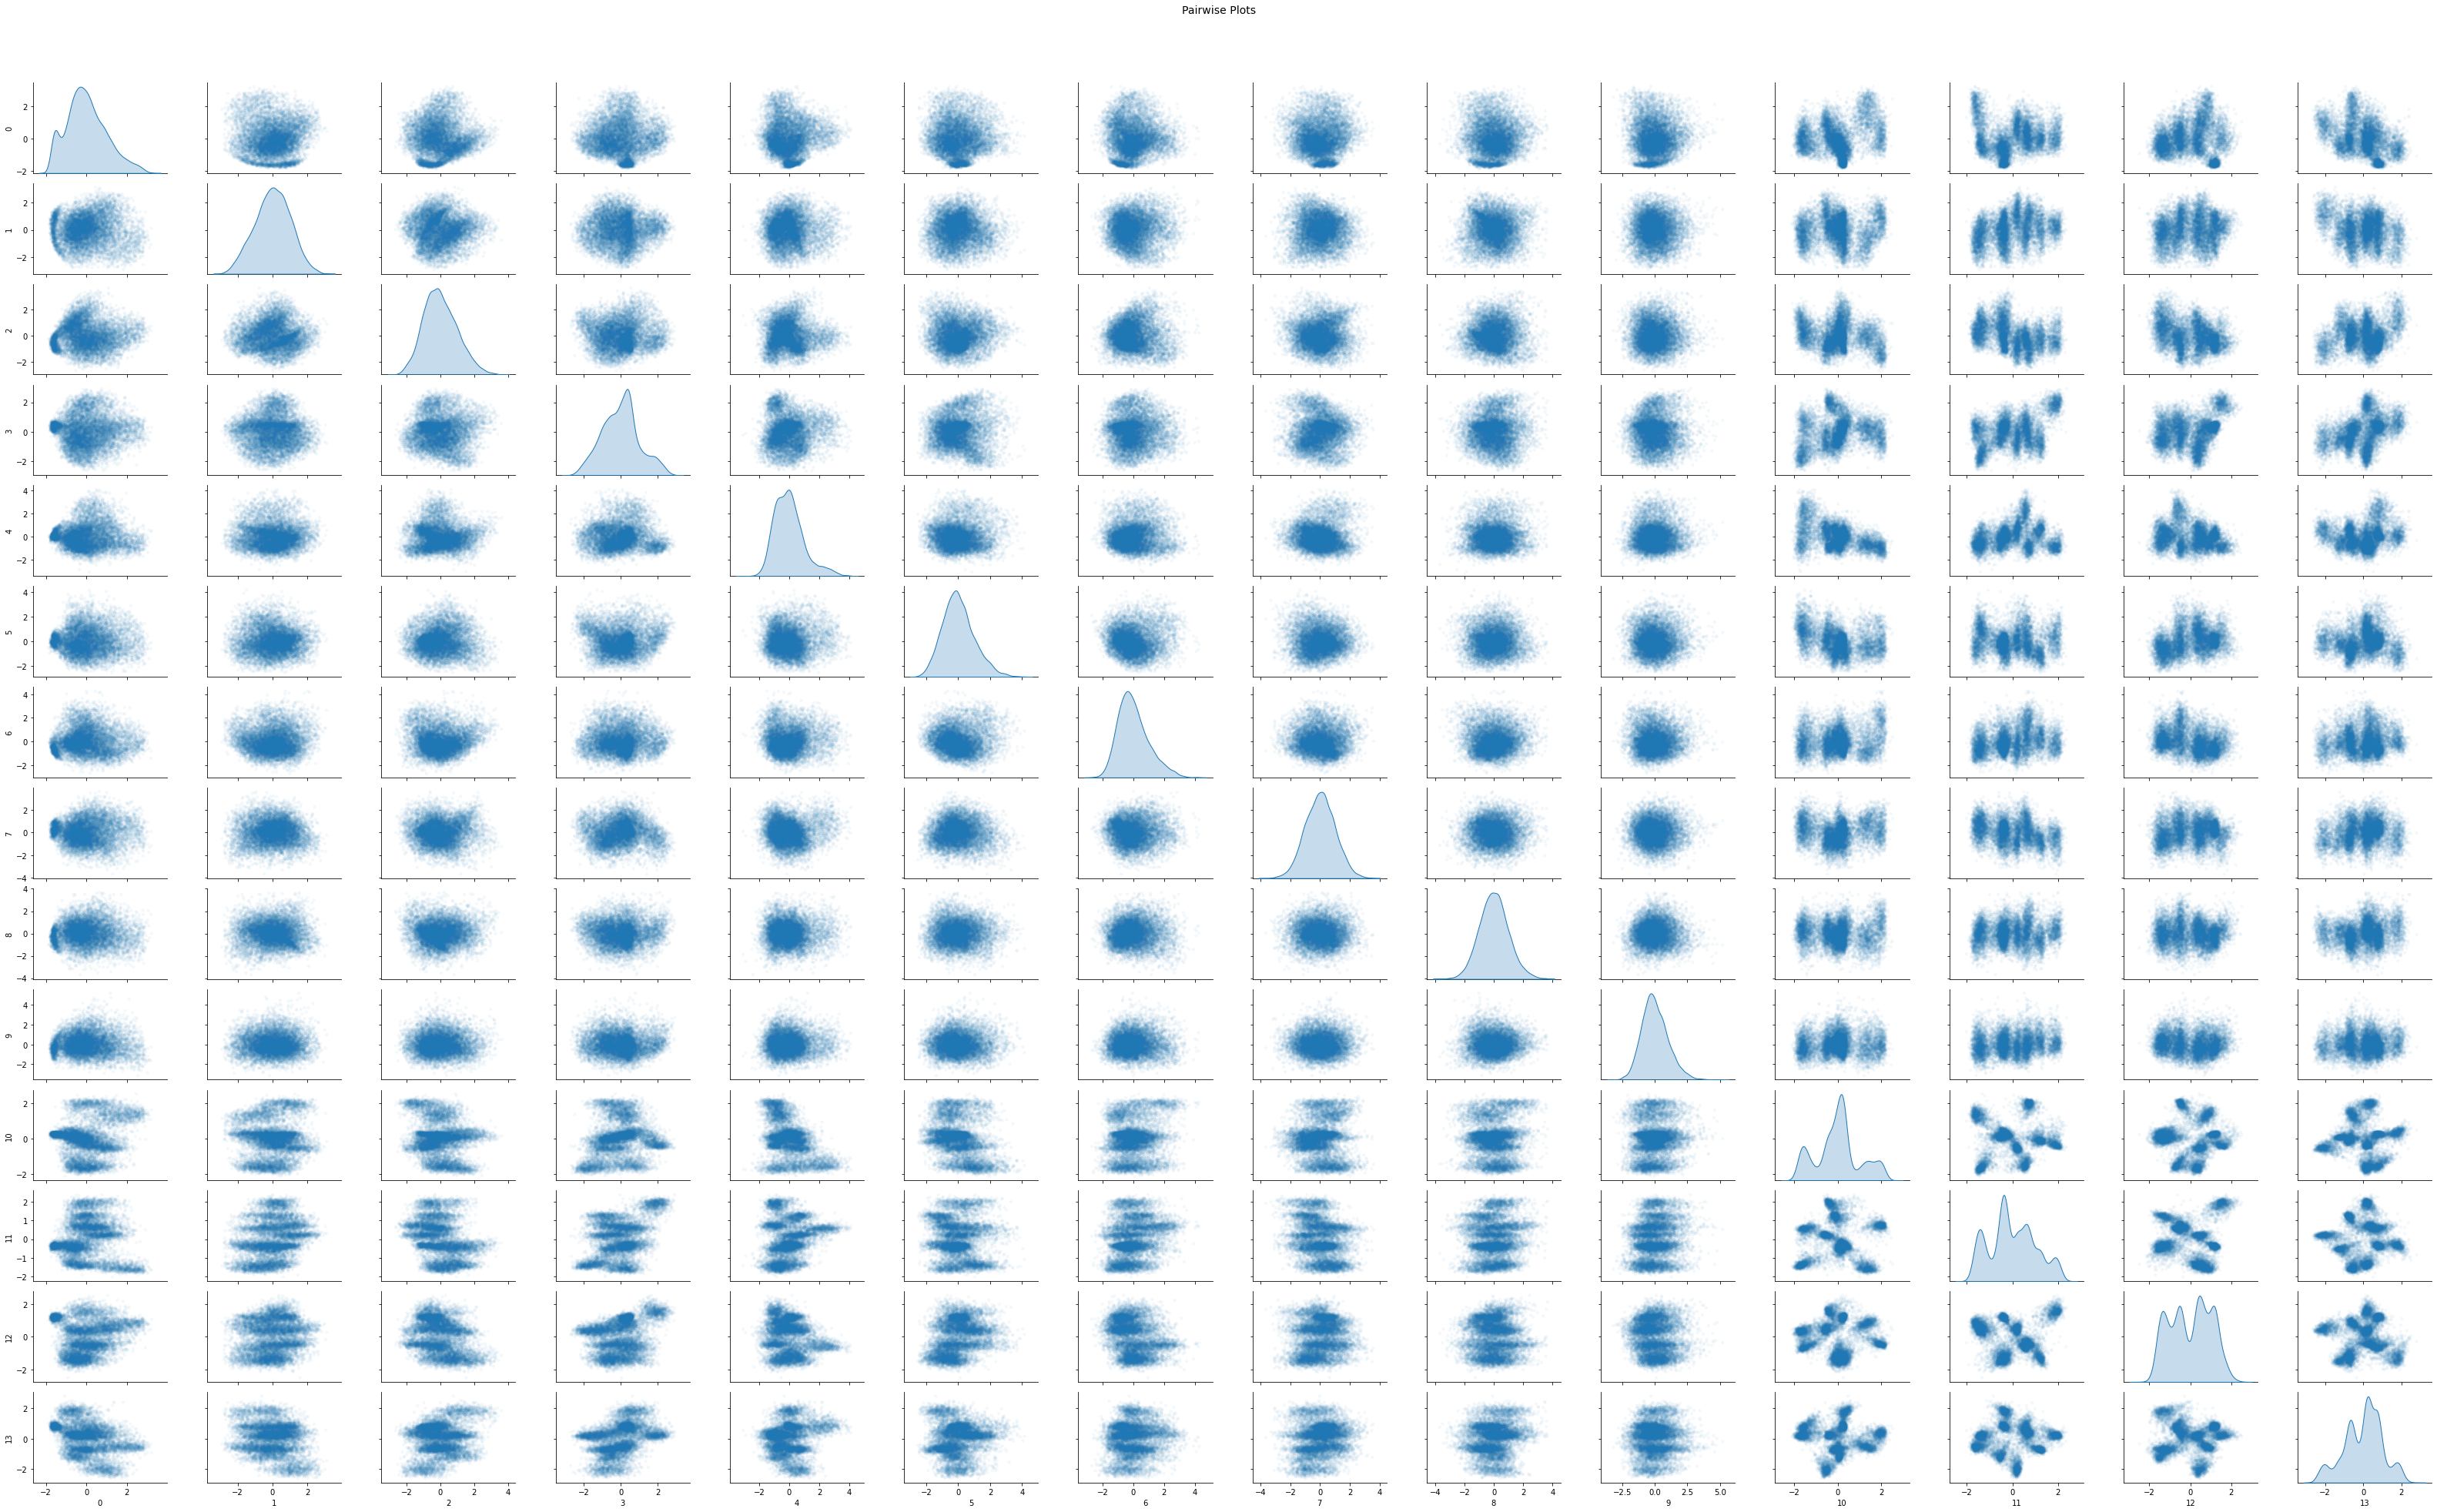

In [62]:
pp = sns.pairplot(pd.DataFrame(codes_pca_X_L[0:10000]), height = 2.0, aspect=1.6,
                      plot_kws=dict(edgecolor="k", linewidth=0.0, alpha=0.05, size=0.01, s=0.01),
                      diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pairwise Plots', fontsize=14)

## Подсчёт взаимной информации

In [63]:
X_L_mi_estimator = MutualInfoEstimator(n_jobs = global_n_jobs)

In [ ]:
X_L_mi_estimator.fit(codes_pca_X, codes_pca_L, verbose=10)

Настройка оценщика для X
Поиск по сетке:  [0.40124255 0.45477469 0.51544888 0.58421797 0.66216195 0.7505049
 0.8506342 ]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.18926535 0.21904095 0.2535009  0.29338216 0.33953762 0.39295434
 0.45477469]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.29338216 0.30802439 0.32339738 0.33953762 0.35648339 0.37427489
 0.39295434]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.30802439 0.31306576 0.31818964 0.32339738 0.32869036 0.33406997
 0.33953762]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.31818964 0.31991617 0.32165207 0.32339738 0.32515217 0.32691648
 0.32869036]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.32165207 0.32223279 0.32281456 0.32339738 0.32398126 0.32456619
 0.32515217]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'algorithm': 'auto', 'atol': 0, '

In [65]:
mutual_information_X_L, mutual_information_X_L_error = X_L_mi_estimator.predict(codes_pca_X, codes_pca_L,
                                                                                verbose=10)

[Parallel(n_jobs=16)]: Done 4400 tasks      | elapsed:   44.0s
[Parallel(n_jobs=16)]: Done 4680 tasks      | elapsed:   47.0s
[Parallel(n_jobs=16)]: Done 4960 tasks      | elapsed:   49.8s
[Parallel(n_jobs=16)]: Done 5256 tasks      | elapsed:   52.6s
[Parallel(n_jobs=16)]: Done 5552 tasks      | elapsed:   55.4s
[Parallel(n_jobs=16)]: Done 5843 tasks      | elapsed:   58.1s
[Parallel(n_jobs=16)]: Done 5931 tasks      | elapsed:   58.9s
[Parallel(n_jobs=16)]: Done 6000 out of 6000 | elapsed:   59.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    3.1s
[Parallel(n_jobs=16)]: Done 352 tasks

[Parallel(n_jobs=16)]: Done 800 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 936 tasks      | elapsed:    9.8s
[Parallel(n_jobs=16)]: Done 1072 tasks      | elapsed:   11.2s
[Parallel(n_jobs=16)]: Done 1224 tasks      | elapsed:   12.5s
[Parallel(n_jobs=16)]: Done 1376 tasks      | elapsed:   13.9s
[Parallel(n_jobs=16)]: Done 1544 tasks      | elapsed:   15.6s
[Parallel(n_jobs=16)]: Done 1712 tasks      | elapsed:   17.2s
[Parallel(n_jobs=16)]: Done 1896 tasks      | elapsed:   19.0s
[Parallel(n_jobs=16)]: Done 2080 tasks      | elapsed:   20.7s
[Parallel(n_jobs=16)]: Done 2280 tasks      | elapsed:   22.6s
[Parallel(n_jobs=16)]: Done 2480 tasks      | elapsed:   24.4s
[Parallel(n_jobs=16)]: Done 2696 tasks      | elapsed:   26.3s
[Parallel(n_jobs=16)]: Done 2912 tasks      | elapsed:   28.4s
[Parallel(n_jobs=16)]: Done 3144 tasks      | elapsed:   30.7s
[Parallel(n_jobs=16)]: Done 3376 tasks      | elapsed:   32.7s
[Parallel(n_jobs=16)]: Done 3624 tasks      | elapsed:   

[Parallel(n_jobs=16)]: Done 4680 tasks      | elapsed:   46.6s
[Parallel(n_jobs=16)]: Done 4960 tasks      | elapsed:   49.2s
[Parallel(n_jobs=16)]: Done 5256 tasks      | elapsed:   52.0s
[Parallel(n_jobs=16)]: Done 5552 tasks      | elapsed:   54.9s
[Parallel(n_jobs=16)]: Done 5843 tasks      | elapsed:   57.8s
[Parallel(n_jobs=16)]: Done 5924 tasks      | elapsed:   58.6s
[Parallel(n_jobs=16)]: Done 6000 out of 6000 | elapsed:   59.1s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    4.3s
[Parallel(n_jobs=16)]: Done 456 tasks 

Оценка энтропии для Y
Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 560 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done 680 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]: Done 800 tasks      | elapsed:    4.1s
[Parallel(n_jobs=16)]: Done 936 tasks      | elapsed:    4.7s
[Parallel(n_jobs=16)]: Done 1072 tasks      | elapsed:    5.4s
[Parallel(n_jobs=16)]: Done 1224 tasks      | elapsed:    6.2s
[Parallel(n_jobs=16)]: Done 1376 tasks      | elapsed:    6.9s
[Parallel(n_jobs=16)]: Done 1544 tasks      | elapsed:    7.6s
[Par

[Parallel(n_jobs=16)]: Done 2280 tasks      | elapsed:   10.8s
[Parallel(n_jobs=16)]: Done 2480 tasks      | elapsed:   11.6s
[Parallel(n_jobs=16)]: Done 2696 tasks      | elapsed:   12.7s
[Parallel(n_jobs=16)]: Done 2912 tasks      | elapsed:   13.6s
[Parallel(n_jobs=16)]: Done 3144 tasks      | elapsed:   14.7s
[Parallel(n_jobs=16)]: Done 3376 tasks      | elapsed:   15.8s
[Parallel(n_jobs=16)]: Done 3624 tasks      | elapsed:   16.9s
[Parallel(n_jobs=16)]: Done 3872 tasks      | elapsed:   18.0s
[Parallel(n_jobs=16)]: Done 4136 tasks      | elapsed:   19.1s
[Parallel(n_jobs=16)]: Done 4400 tasks      | elapsed:   20.4s
[Parallel(n_jobs=16)]: Done 4680 tasks      | elapsed:   21.7s
[Parallel(n_jobs=16)]: Done 4960 tasks      | elapsed:   23.1s
[Parallel(n_jobs=16)]: Done 5256 tasks      | elapsed:   24.3s
[Parallel(n_jobs=16)]: Done 5552 tasks      | elapsed:   25.7s
[Parallel(n_jobs=16)]: Done 5843 tasks      | elapsed:   27.0s
[Parallel(n_jobs=16)]: Done 5938 tasks      | elapsed: 

[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 560 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 680 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 800 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 936 tasks      | elapsed:    3.3s
[Parallel(n_jobs=16)]: Done 1072 tasks      | elapsed:    3.8s
[Parallel(n_jobs=16)]: Done 1224 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done 1376 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Done 1544 tasks      | elapsed:    5.0s
[Parallel(n_jobs=16)]: Done 1712 tasks      | elapsed:    5.7s
[Parallel(n_jobs=16)]: Done 1896 tasks      | elapsed:    6.3s
[Parallel(n_jobs=16)]: Done 2080 tasks      | elapsed:    7.1s
[

Оценка энтропии для (X,Y)
Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    4.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    5.8s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    6.8s
[Parallel(n_jobs=16)]: Done 560 tasks      | elapsed:    8.2s
[Parallel(n_jobs=16)]: Done 680 tasks      | elapsed:    9.9s
[Parallel(n_jobs=16)]: Done 800 tasks      | elapsed:   11.7s
[Parallel(n_jobs=16)]: Done 936 tasks      | elapsed:   13.3s
[Parallel(n_jobs=16)]: Done 1072 tasks      | elapsed:   15.4s
[Parallel(n_jobs=16)]: Done 1224 tasks      | elapsed:   17.1s
[Parallel(n_jobs=16)]: Done 1376 tasks      | elapsed

[Parallel(n_jobs=16)]: Done 2080 tasks      | elapsed:   27.4s
[Parallel(n_jobs=16)]: Done 2280 tasks      | elapsed:   30.1s
[Parallel(n_jobs=16)]: Done 2480 tasks      | elapsed:   32.6s
[Parallel(n_jobs=16)]: Done 2696 tasks      | elapsed:   35.4s
[Parallel(n_jobs=16)]: Done 2912 tasks      | elapsed:   38.0s
[Parallel(n_jobs=16)]: Done 3144 tasks      | elapsed:   40.8s
[Parallel(n_jobs=16)]: Done 3376 tasks      | elapsed:   43.7s
[Parallel(n_jobs=16)]: Done 3624 tasks      | elapsed:   46.8s
[Parallel(n_jobs=16)]: Done 3872 tasks      | elapsed:   49.6s
[Parallel(n_jobs=16)]: Done 4136 tasks      | elapsed:   52.8s
[Parallel(n_jobs=16)]: Done 4400 tasks      | elapsed:   56.0s
[Parallel(n_jobs=16)]: Done 4680 tasks      | elapsed:   59.3s
[Parallel(n_jobs=16)]: Done 4960 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done 5256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 5552 tasks      | elapsed:  1.2min
[Parallel(n_jobs=16)]: Done 5836 tasks      | elapsed: 

[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    4.1s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    4.4s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    6.1s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    7.9s
[Parallel(n_jobs=16)]: Done 560 tasks      | elapsed:    8.6s
[Parallel(n_jobs=16)]: Done 680 tasks      | elapsed:   10.0s
[Parallel(n_jobs=16)]: Done 800 tasks      | elapsed:   11.9s
[Parallel(n_jobs=16)]: Done 936 tasks      | elapsed:   13.7s
[Parallel(n_jobs=16)]: Done 1072 tasks      | elapsed:   15.6s
[Parallel(n_jobs=16)]: Done 1224 tasks      | elapsed:   17.5s
[Parallel(n_jobs=16)]: Done 1376 tasks      | elapsed:   19.5s
[Parallel(n_jobs=16)]: Done 1544 tasks      | elapsed:   22.4s
[Par

In [66]:
info['mutual_information_X_L'] = mutual_information_X_L
info['mutual_information_X_L_error'] = mutual_information_X_L_error

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp, indent=4)

In [67]:
L_Y_mi_estimator = MutualInfoEstimator(n_jobs = global_n_jobs, Y_is_discrette=True)

In [68]:
L_Y_mi_estimator.fit(codes_pca_L, ds_train_Y, verbose=10)

Настройка оценщика для X
Поиск по сетке:  [0.28844462 0.32692772 0.37054509 0.4199817  0.47601395 0.53952179
 0.61150259]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.13605878 0.15746382 0.18223633 0.21090611 0.24408628 0.28248641
 0.32692772]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.05662411 0.06714773 0.07962715 0.09442589 0.11197498 0.13278557
 0.15746382]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.06714773 0.07107354 0.07522887 0.07962715 0.08428258 0.08921019
 0.09442589]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.07962715 0.08114967 0.08270129 0.08428258 0.08589411 0.08753645
 0.08921019]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.08114967 0.08166361 0.08218081 0.08270129 0.08322506 0.08375215
 0.08428258]
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Поиск по сетке:  [0.08166361 0.08

In [69]:
mutual_information_L_Y, mutual_information_L_Y_error = L_Y_mi_estimator.predict(codes_pca_L, ds_train_Y.astype(np.int32),
                                                                                verbose=10)

Оценка энтропии для X
Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 560 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 680 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]: Done 800 tasks      | elapsed:    4.1s
[Parallel(n_jobs=16)]: Done 936 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 1072 tasks      | elapsed:    5.4s
[Parallel(n_jobs=16)]: Done 1224 tasks      | elapsed:    6.1s
[Parallel(n_jobs=16)]: Done 1376 tasks      | elapsed

[Parallel(n_jobs=16)]: Done 2080 tasks      | elapsed:    9.9s
[Parallel(n_jobs=16)]: Done 2280 tasks      | elapsed:   10.8s
[Parallel(n_jobs=16)]: Done 2480 tasks      | elapsed:   11.6s
[Parallel(n_jobs=16)]: Done 2696 tasks      | elapsed:   12.6s
[Parallel(n_jobs=16)]: Done 2912 tasks      | elapsed:   13.7s
[Parallel(n_jobs=16)]: Done 3144 tasks      | elapsed:   14.8s
[Parallel(n_jobs=16)]: Done 3376 tasks      | elapsed:   15.8s
[Parallel(n_jobs=16)]: Done 3624 tasks      | elapsed:   16.8s
[Parallel(n_jobs=16)]: Done 3872 tasks      | elapsed:   17.8s
[Parallel(n_jobs=16)]: Done 4136 tasks      | elapsed:   19.0s
[Parallel(n_jobs=16)]: Done 4400 tasks      | elapsed:   20.0s
[Parallel(n_jobs=16)]: Done 4680 tasks      | elapsed:   21.1s
[Parallel(n_jobs=16)]: Done 4960 tasks      | elapsed:   22.2s
[Parallel(n_jobs=16)]: Done 5256 tasks      | elapsed:   23.3s
[Parallel(n_jobs=16)]: Done 5552 tasks      | elapsed:   24.3s
[Parallel(n_jobs=16)]: Done 5850 tasks      | elapsed: 

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 560 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 680 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 800 tasks      | elapsed:    4.0s
[Parallel(n_jobs=16)]: Done 936 tasks      | elapsed:    4.7s
[Parallel(n_jobs=16)]: Done 1072 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done 1224 tasks      | elapsed:    5.9s
[Parallel(n_jobs=16)]: Done 1376 tasks      | elapsed:    6.5s
[Parallel(n_jobs=16)]: Done 1544 tasks      | elapsed:    7.3s
[Parallel(n_jobs=16)]: Done 1712 tasks      | elapsed:    8.1s
[Pa

Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 560 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 675 out of 675 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | e

Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 525 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 561 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 585 out of 585 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | e

Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 525 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 561 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 576 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18

Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 525 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 561 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 576 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 593 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 610 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 627 out of 627 | elapsed:    0.9s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | e

[Parallel(n_jobs=16)]: Done 627 out of 627 | elapsed:    0.9s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 525 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 561 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 576 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 593 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 622 out of 622 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend 

Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 539 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 561 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 586 out of 586 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | e

Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 525 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 561 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 576 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 596 out of 596 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | e

Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 518 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 561 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 576 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 592 out of 592 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | e

Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 525 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 561 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 576 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 593 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 614 out of 614 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | e

[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 525 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 561 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 576 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 605 out of 605 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s


Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 456 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 525 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 561 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 576 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 595 out of 595 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 264 tasks      | e

Восстановлено блоков данных: 0


[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 414 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 464 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 481 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 498 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 517 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 543 out of 543 | elapsed:    1.0s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 conc

[Parallel(n_jobs=16)]: Done 264 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 414 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 464 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 481 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 498 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 517 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 543 out of 543 | elapsed:    1.0s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 176 tasks      | e

In [70]:
print("(X;L) mutual information: %.2f ± %.2f" % (mutual_information_X_L, mutual_information_X_L_error))
print("(L;Y) mutual information: %.2f ± %.2f" % (mutual_information_L_Y, mutual_information_L_Y_error))

(X;L) mutual information: 0.95 ± 0.22
(L;Y) mutual information: 2.28 ± 0.05
